<a href="https://colab.research.google.com/github/VidithSomanna/Adv_AI/blob/main/AdvAI_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/heart.csv"


Mounted at /content/drive


In [ ]:
# Cell 1 - Imports & helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import check_array

# ART imports (install if missing)
try:
    from art.estimators.classification import SklearnClassifier
    from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
except Exception:
    print('Installing adversarial-robustness-toolbox...')
    !pip install -q adversarial-robustness-toolbox
    from art.estimators.classification import SklearnClassifier
    from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

# Helper: robust mean-abs SHAP extraction (handles Explainer/TreeExplainer returns)
def mean_abs_shap_for_explainer(explainer, X_eval, class_index=1):
    try:
        vals = explainer.shap_values(X_eval)
    except Exception:
        out = explainer(X_eval)
        vals = getattr(out, 'values', out)
    if isinstance(vals, (list, tuple)):
        if len(vals) > class_index:
            arr = np.abs(vals[class_index])
        else:
            arr = np.mean([np.abs(v) for v in vals], axis=0)
    else:
        vals = np.asarray(vals)
        if vals.ndim == 3:
            if vals.shape[0] > class_index:
                arr = np.abs(vals[class_index])
            else:
                arr = np.mean(np.abs(vals), axis=0)
        else:
            arr = np.abs(vals)
    return np.mean(arr, axis=0)

def save_fig(name):
    plt.savefig(name, dpi=300, bbox_inches='tight')
    print(f"Saved {name}")


In [ ]:
import pandas as pd

df = pd.read_csv(path)
print(df.shape)
df.head()


(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
from sklearn.model_selection import train_test_split

# Separate features & target
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
print('Scaling complete.')


Scaling complete.


In [ ]:
# Cell 5 - Train models: LogisticRegression (for gradient attacks) and RandomForest (tree baseline)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Logistic uses scaled features; RandomForest uses original features
log_reg.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)

print('Trained LogisticRegression and RandomForest.')


Trained LogisticRegression and RandomForest.


In [ ]:
# Cell 6 - Baseline evaluation on test set
def evaluate(model, Xt, yt, name='model'):
    preds = model.predict(Xt)
    probs = None
    try:
        probs = model.predict_proba(Xt)[:,1]
    except Exception:
        pass
    acc = accuracy_score(yt, preds)
    prec = precision_score(yt, preds, zero_division=0)
    rec = recall_score(yt, preds, zero_division=0)
    f1 = f1_score(yt, preds, zero_division=0)
    roc = roc_auc_score(yt, probs) if probs is not None else float('nan')
    print(f'[{name}] Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc:.4f}')
    return {'acc':acc,'prec':prec,'rec':rec,'f1':f1,'roc':roc}

print('LogisticRegression (scaled inputs):')
metrics_lr = evaluate(log_reg, X_test_scaled, y_test, 'LogisticRegression')
print('\nRandomForest (original inputs):')
metrics_rf = evaluate(rf, X_test, y_test, 'RandomForest')


LogisticRegression (scaled inputs):
[LogisticRegression] Acc=0.7951, Prec=0.7563, Rec=0.8738, F1=0.8108, ROC-AUC=0.8787

RandomForest (original inputs):
[RandomForest] Acc=0.9854, Prec=1.0000, Rec=0.9709, F1=0.9852, ROC-AUC=1.0000


Saved shap_summary_lr.png


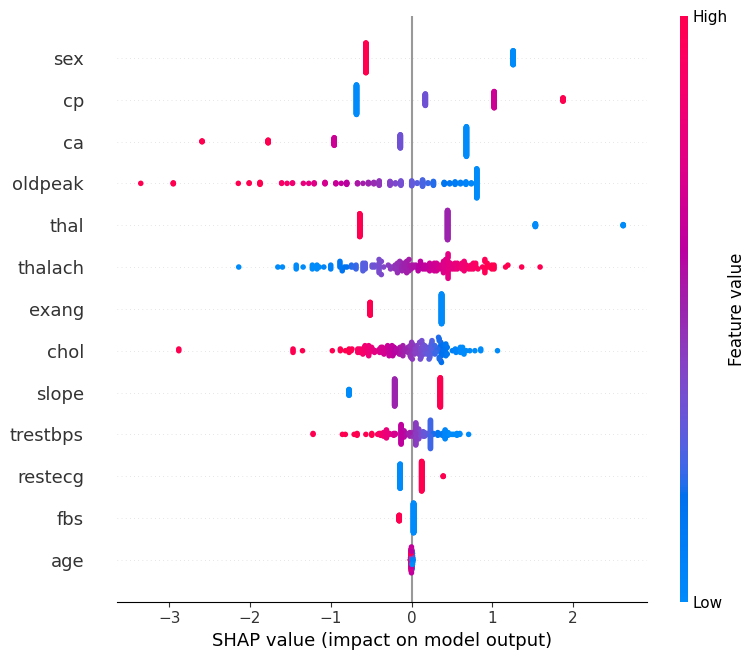

In [ ]:
# Cell 7 - SHAP baseline for LogisticRegression (scaled inputs)
explainer_lr = shap.Explainer(log_reg, X_train_scaled)
shap_orig_lr = explainer_lr(X_test_scaled)
# summary plot (may open a window in notebook)
shap.summary_plot(shap_orig_lr, X_test_scaled, show=False)
save_fig('shap_summary_lr.png')


Saved shap_summary_rf.png


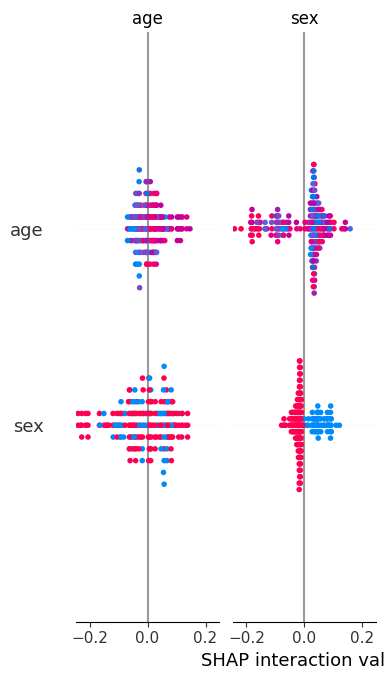

In [ ]:
# Cell 8 - SHAP baseline for RandomForest (unscaled)
try:
    expl_rf = shap.TreeExplainer(rf)
    shap_vals_rf = expl_rf.shap_values(X_test)
    shap.summary_plot(shap_vals_rf, X_test, show=False)
    save_fig('shap_summary_rf.png')
except Exception as e:
    print('TreeExplainer failed for RF:', e)
    bg = shap.sample(X_train, min(100, X_train.shape[0]), random_state=42)
    expl_rf = shap.KernelExplainer(rf.predict_proba, bg)
    shap_vals_rf = expl_rf.shap_values(X_test.iloc[:200])
    shap.summary_plot(shap_vals_rf, X_test.iloc[:200], show=False)
    save_fig('shap_summary_rf_kernel.png')


In [ ]:
# Cell 9 - Save baseline mean-abs SHAP per feature (LR)
base_shap_lr = np.abs(shap_orig_lr.values).mean(axis=0)
df_base_lr = pd.DataFrame({'Feature': X_test_scaled.columns, 'MeanAbsSHAP': base_shap_lr}).sort_values('MeanAbsSHAP', ascending=False)
df_base_lr.to_csv('base_shap_lr.csv', index=False)
print('Saved base_shap_lr.csv')


Saved base_shap_lr.csv


In [ ]:
# Cell 10 - Generate adversarials (FGSM tried across eps list; PGD fallback)
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
assert 'log_reg' in globals(), 'log_reg must be defined'
Xs = (X_test_scaled.to_numpy()).astype('float32')
art_clf = SklearnClassifier(model=log_reg)

eps_list = [0.01, 0.05, 0.1, 0.15, 0.2]
selected = None
for eps in eps_list:
    try:
        atk = FastGradientMethod(estimator=art_clf, eps=eps)
        X_adv_try = atk.generate(Xs)
    except Exception as e:
        print('FGSM failed for eps', eps, e)
        continue
    preds_orig = log_reg.predict(Xs)
    preds_adv  = log_reg.predict(X_adv_try)
    unchanged_pct = 100*np.mean(preds_orig==preds_adv)
    mean_abs = np.mean(np.abs(X_adv_try - Xs))
    print(f'FGSM eps={eps} -> mean_abs={mean_abs:.6e}, unchanged%={unchanged_pct:.2f}')
    if unchanged_pct < 95.0:
        selected = ('fgsm', eps, X_adv_try)
        break
if selected is None:
    print('FGSM insufficient; trying PGD...')
    try:
        atk = ProjectedGradientDescent(estimator=art_clf, eps=0.15, eps_step=0.02, max_iter=40)
        X_adv_pgd = atk.generate(Xs)
        preds_adv = log_reg.predict(X_adv_pgd)
        unchanged_pct = 100*np.mean(preds_orig==preds_adv)
        mean_abs = np.mean(np.abs(X_adv_pgd - Xs))
        print(f'PGD -> mean_abs={mean_abs:.6e}, unchanged%={unchanged_pct:.2f}')
        if unchanged_pct < 98.0:
            selected = ('pgd', 0.15, X_adv_pgd)
    except Exception as e:
        print('PGD failed:', e)
if selected is None:
    X_adv_final = X_adv_try
    print('Using fallback FGSM output.')
else:
    used_method, used_eps, X_adv_final = selected
    print('Selected attack', used_method, used_eps)
# Save as DataFrame with scaled columns
X_adv = pd.DataFrame(X_adv_final, columns=X_test_scaled.columns)
X_adv.to_csv('X_adv_generated.csv', index=False)
print('Saved X_adv_generated.csv')


FGSM eps=0.01 -> mean_abs=9.999992e-03, unchanged%=98.05
FGSM eps=0.05 -> mean_abs=4.999999e-02, unchanged%=90.24
Selected attack fgsm 0.05
Saved X_adv_generated.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

In [ ]:
# Cell 11 - Sanity checks for adversarial set (run right after Cell 10)
def to_np(X):
    return X.values if hasattr(X, 'values') else np.asarray(X)
Xs = to_np(X_test_scaled).astype(float)
Xa = to_np(X_adv).astype(float)
mean_abs_perturb = np.mean(np.abs(Xa - Xs))
max_abs_perturb = np.max(np.abs(Xa - Xs))
print('mean abs perturb:', mean_abs_perturb, 'max abs perturb:', max_abs_perturb)
if 'log_reg' in globals():
    print('LogReg % unchanged:', 100*np.mean(log_reg.predict(Xs) == log_reg.predict(Xa)))
if 'rf' in globals():
    try:
        df_adv_tree = pd.DataFrame(Xa, columns=X_test.columns)
        print('RF % unchanged:', 100*np.mean(rf.predict(X_test) == rf.predict(df_adv_tree)))
    except Exception as e:
        print('RF predict check failed:', e)


mean abs perturb: 0.049999997271982545 max abs perturb: 0.05000016877538993
LogReg % unchanged: 90.2439024390244
RF % unchanged: 72.1951219512195


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
# Cell 12 - SHAP original vs adversarial for LogisticRegression (scaled)
explainer_lr = shap.Explainer(log_reg, X_train_scaled)
shap_orig_lr = explainer_lr(X_test_scaled)
shap_adv_lr  = explainer_lr(X_adv)
base_shap_mean = np.abs(shap_orig_lr.values).mean(axis=0)
adv_shap_mean  = np.abs(shap_adv_lr.values).mean(axis=0)
df_lr = pd.DataFrame({'Feature': X_test_scaled.columns, 'Original_SHAP': base_shap_mean, 'Adversarial_SHAP': adv_shap_mean})
df_lr['Change'] = np.abs(df_lr['Original_SHAP'] - df_lr['Adversarial_SHAP'])
df_lr['Change_%'] = 100*df_lr['Change']/(df_lr['Original_SHAP']+1e-9)
df_lr = df_lr.sort_values('Change_%', ascending=False).reset_index(drop=True)
df_lr.head(15)


,Feature,Original_SHAP,Adversarial_SHAP,Change,Change_%
0,cp,0.746141,0.720431,0.025711,3.445838
1,exang,0.414032,0.402040,0.011992,2.896415
2,thalach,0.544865,0.529401,0.015464,2.838062
3,thal,0.636593,0.619451,0.017142,2.692827
4,slope,0.333169,0.324202,0.008967,2.691501
5,oldpeak,0.673911,0.656411,0.017499,2.596659
6,ca,0.683161,0.665591,0.017571,2.571951
7,age,0.005215,0.005140,0.000075,1.436899
8,restecg,0.136317,0.134977,0.001339,0.982536
9,sex,0.788406,0.781272,0.007134,0.904831


In [ ]:
# Cell 13 - SHAP original vs adversarial for RandomForest (unscaled)
try:
    expl_rf = shap.TreeExplainer(rf)
    shap_orig_rf = expl_rf.shap_values(X_test)
    shap_adv_rf = expl_rf.shap_values(pd.DataFrame(X_adv.values, columns=X_test.columns))
    if isinstance(shap_orig_rf, list):
        orig_vals = np.abs(shap_orig_rf[1]).mean(axis=0)
        adv_vals = np.abs(shap_adv_rf[1]).mean(axis=0)
    else:
        orig_vals = np.abs(shap_orig_rf).mean(axis=0)
        adv_vals = np.abs(shap_adv_rf).mean(axis=0)
    df_rf = pd.DataFrame({'Feature': X_test.columns, 'Original_SHAP': orig_vals, 'Adversarial_SHAP': adv_vals})
    df_rf['Change'] = np.abs(df_rf['Original_SHAP'] - df_rf['Adversarial_SHAP'])
    df_rf['Change_%'] = 100*df_rf['Change']/(df_rf['Original_SHAP']+1e-9)
    df_rf = df_rf.sort_values('Change_%', ascending=False).reset_index(drop=True)
    df_rf.head(15)
except Exception as e:
    print('Tree SHAP failed:', e)


Tree SHAP failed: Per-column arrays must each be 1-dimensional


In [ ]:
# Cell 14 - Robustness metrics (choose df_lr as preferred)
robustness_adv_df = df_lr.copy()
orig = robustness_adv_df['Original_SHAP'].values
adv  = robustness_adv_df['Adversarial_SHAP'].values
spearman_corr = spearmanr(orig, adv).correlation if not (np.allclose(orig,0) or np.allclose(adv,0)) else float('nan')
top5 = 5
top_orig = set(robustness_adv_df.nlargest(top5, 'Original_SHAP')['Feature'])
top_adv  = set(robustness_adv_df.nlargest(top5, 'Adversarial_SHAP')['Feature'])
jaccard_top5 = len(top_orig & top_adv)/len(top_orig | top_adv)
masd = np.mean(np.abs(orig-adv))
metrics_df = pd.DataFrame([{'Preferred_Model':'LogisticRegression','Spearman':spearman_corr,'Top5_Jaccard':jaccard_top5,'MeanAbsSHAPDev':masd,'MeanAbsPerturb':mean_abs_perturb}])
metrics_df.to_csv('shap_robustness_summary.csv', index=False)
display(metrics_df)


,Preferred_Model,Spearman,Top5_Jaccard,MeanAbsSHAPDev,MeanAbsPerturb
0,LogisticRegression,1.0,1.0,0.009779,0.05


Saved shap_orig_vs_adv_scatter.png


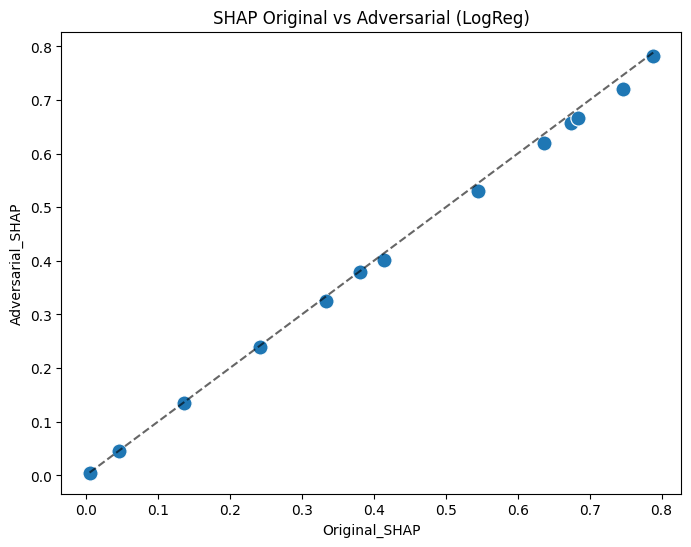

/tmp/ipython-input-211427456.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=robustness_adv_df.head(10), x='Change_%', y='Feature', palette='magma')


Saved top10_change_adv.png


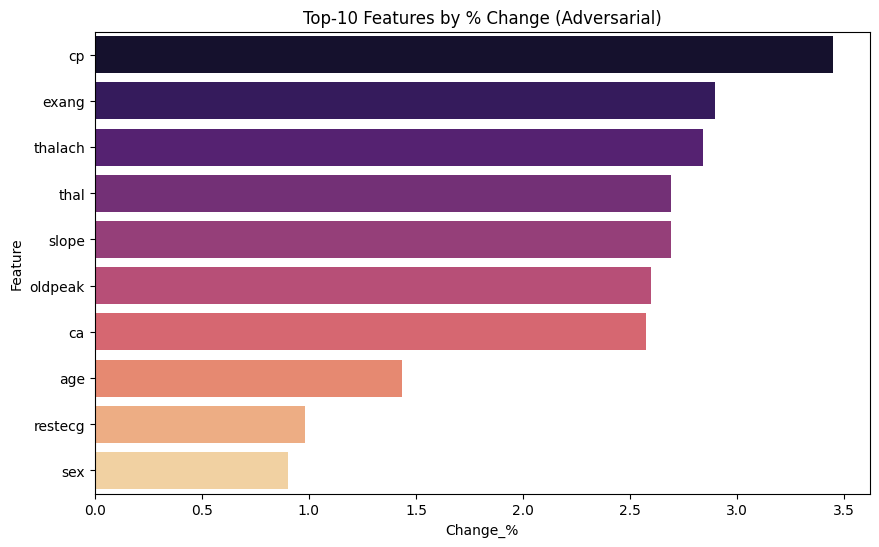

In [ ]:
# Cell 15 - Plots: scatter and top-change bar
plt.figure(figsize=(8,6))
sns.scatterplot(data=robustness_adv_df, x='Original_SHAP', y='Adversarial_SHAP', s=120)
mn = min(robustness_adv_df['Original_SHAP'].min(), robustness_adv_df['Adversarial_SHAP'].min())
mx = max(robustness_adv_df['Original_SHAP'].max(), robustness_adv_df['Adversarial_SHAP'].max())
plt.plot([mn,mx],[mn,mx],'k--',alpha=0.6)
plt.title('SHAP Original vs Adversarial (LogReg)')
save_fig('shap_orig_vs_adv_scatter.png')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=robustness_adv_df.head(10), x='Change_%', y='Feature', palette='magma')
plt.title('Top-10 Features by % Change (Adversarial)')
save_fig('top10_change_adv.png')
plt.show()


In [ ]:
# Cell 16 - Robustness curve across epsilons (FGSM)
eps_values = [0.01, 0.05, 0.1, 0.2]
results = []
art_clf = SklearnClassifier(model=log_reg)
explainer = shap.Explainer(log_reg, X_train_scaled)
base_shap = np.abs(explainer(X_test_scaled).values).mean(axis=0)
for eps in eps_values:
    print('Running eps', eps)
    try:
        atk = FastGradientMethod(estimator=art_clf, eps=eps)
        X_adv_try = atk.generate((X_test_scaled.to_numpy()).astype('float32'))
    except Exception as e:
        print('FGSM failed for eps', eps, e)
        continue
    shap_adv = np.abs(explainer(X_adv_try).values).mean(axis=0)
    spearman_corr = spearmanr(base_shap, shap_adv).correlation
    top5_base = set(pd.Series(base_shap, index=X_test_scaled.columns).nlargest(5).index)
    top5_adv  = set(pd.Series(shap_adv, index=X_test_scaled.columns).nlargest(5).index)
    jaccard_top5 = len(top5_base & top5_adv)/len(top5_base | top5_adv)
    mean_abs_shap_dev = np.mean(np.abs(base_shap - shap_adv))
    results.append({'Epsilon':eps,'Spearman':spearman_corr,'Jaccard_Top5':jaccard_top5,'MeanAbsSHAPDev':mean_abs_shap_dev})
robustness_curve_df = pd.DataFrame(results)
robustness_curve_df.to_csv('shap_robustness_curve.csv', index=False)
display(robustness_curve_df)


Running eps 0.01
Running eps 0.05
Running eps 0.1
Running eps 0.2


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

,Epsilon,Spearman,Jaccard_Top5,MeanAbsSHAPDev
0,0.01,1.000000,1.0,0.001979
1,0.05,1.000000,1.0,0.009779
2,0.10,1.000000,1.0,0.019309
3,0.20,0.994505,1.0,0.036618


In [ ]:
# Cell 17 - Manual perturbation targeted to top features (for tree models)
if 'df_rf' not in globals():
    print('df_rf not computed; run tree SHAP first.')
else:
    top_feats = list(df_rf.head(3)['Feature'])
    print('Top features:', top_feats)
    X_adv_manual = X_test.copy()
    rows_to_modify = int(0.3*len(X_adv_manual))
    inds = np.random.choice(len(X_adv_manual), size=rows_to_modify, replace=False)
    for f in top_feats:
        if f not in X_adv_manual.columns:
            continue
        delta = 0.2 * X_adv_manual[f].std()
        X_adv_manual.loc[inds, f] += delta
    X_adv_tree = X_adv_manual
    X_adv_tree.to_csv('X_adv_tree_manual.csv', index=False)
    print('Saved manual tree perturbations')


df_rf not computed; run tree SHAP first.


In [ ]:
# Cell 18 - Recompute SHAP for RF using manual perturbations if created
if 'X_adv_tree' in globals():
    try:
        expl_rf = shap.TreeExplainer(rf)
        shap_adv_rf_manual = expl_rf.shap_values(X_adv_tree)
        if isinstance(shap_adv_rf_manual, list):
            adv_vals_m = np.abs(shap_adv_rf_manual[1]).mean(axis=0)
        else:
            adv_vals_m = np.abs(shap_adv_rf_manual).mean(axis=0)
        print('Recomputed SHAP on manually perturbed tree data.')
    except Exception as e:
        print('Tree SHAP failed on manual adv:', e)
else:
    print('No X_adv_tree found.')


No X_adv_tree found.


In [ ]:
# Cell 19 - Save CSVs and key PNGs for report
# ensure files exist and list them
for fname in ['base_shap_lr.csv','X_adv_generated.csv','shap_robustness_summary.csv','shap_robustness_curve.csv']:
    print(fname, '->', os.path.exists(fname))
# display sample files
try:
    display(pd.read_csv('shap_robustness_summary.csv'))
except Exception as e:
    print('Could not display summary csv:', e)


base_shap_lr.csv -> True
X_adv_generated.csv -> True
shap_robustness_summary.csv -> True
shap_robustness_curve.csv -> True


,Preferred_Model,Spearman,Top5_Jaccard,MeanAbsSHAPDev,MeanAbsPerturb
0,LogisticRegression,1.0,1.0,0.009779,0.05


In [ ]:
# Cell 21 - Utility: load saved CSVs if needed
def load_summary():
    try:
        df = pd.read_csv('shap_robustness_summary.csv')
        print(df)
    except Exception as e:
        print('Could not load shap_robustness_summary.csv:', e)
load_summary()


      Preferred_Model  Spearman  Top5_Jaccard  MeanAbsSHAPDev  MeanAbsPerturb
0  LogisticRegression       1.0           1.0        0.009779            0.05


In [ ]:
# Cell 22 - Utility: quick inspect of adv samples
try:
    display(pd.read_csv('X_adv_generated.csv').head())
except Exception as e:
    print('X_adv not saved or not found:', e)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.883168,-1.477525,-0.966720,-0.388694,-0.676281,-0.364039,0.859846,0.545660,-0.675949,-0.862152,0.955264,-0.675467,-0.495193
1,-0.099222,-1.477525,0.958275,-0.161520,-0.535261,-0.364039,-1.033742,-1.549156,-0.675949,-0.862152,0.955264,-0.675467,-3.806737
2,0.019087,0.604654,-0.866720,1.555865,0.835384,-0.464039,-0.933742,-0.139896,1.327507,-0.260661,-0.590078,0.190252,1.060579
3,-0.426686,-1.477525,-0.004223,-0.615867,0.028822,-0.364039,0.859846,0.502018,-0.675949,0.102398,0.955264,-0.675467,-0.495193
4,-0.744995,0.604654,-0.866720,-0.147934,0.170572,2.365230,-0.933742,0.078314,1.327507,-0.962152,1.055264,1.155972,1.060579


In [ ]:
# -------------------------------------------
# Cell 23 — Train scikit-learn MLP Classifier
# -------------------------------------------

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

print("Training MLPClassifier on scaled features...")

# MLP hyperparameters tuned for:
# - Stable convergence
# - Compatibility with ART + HopSkipJump
# - Good performance on tabular datasets

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # two-layer MLP
    activation='relu',
    solver='adam',
    max_iter=500,
    alpha=1e-4,
    learning_rate='adaptive',
    random_state=42,
    verbose=False
)

mlp.fit(X_train_scaled, y_train)

# Evaluate on test set
y_pred_mlp = mlp.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred_mlp)

print(f"\nMLP Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))

# Store predictions if needed later
mlp_preds = y_pred_mlp

print("Cell 23 completed successfully. MLPClassifier is ready for Cell 24.")


Training MLPClassifier on scaled features...

MLP Test Accuracy: 0.9854

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Cell 23 completed successfully. MLPClassifier is ready for Cell 24.


In [ ]:
# --- Robust collapse + mean calculation for SHAP outputs (replace old block) ---
import numpy as np
import pandas as pd

def collapse_and_mean_abs(shap_arr):
    """
    Accepts shap values in many shapes:
      - (n_samples, n_features)
      - (1, n_samples, n_features)
      - (k, n_samples, n_features)  (rare)
      - (n_features,) (already aggregated)
    Returns: 1D array of length n_features with mean(abs(shap)) across sample-like dims.
    """
    arr = np.asarray(shap_arr)
    if arr.ndim == 1:
        # already a feature vector
        return np.abs(arr)
    elif arr.ndim >= 2:
        # collapse all leading dims except last (features)
        arr2 = arr.reshape(-1, arr.shape[-1])   # shape (num_examples, n_features)
        return np.abs(arr2).mean(axis=0)
    else:
        raise ValueError(f"Unexpected SHAP array ndim: {arr.ndim}")

# compute robustly from the previously obtained shap_orig_list / shap_adv_list
# (these are what KernelExplainer.shap_values returned earlier)
if isinstance(shap_orig_list, (list, tuple)) and len(shap_orig_list) > 1:
    raw_orig = shap_orig_list[1]
else:
    raw_orig = shap_orig_list

if isinstance(shap_adv_list, (list, tuple)) and len(shap_adv_list) > 1:
    raw_adv = shap_adv_list[1]
else:
    raw_adv = shap_adv_list

# Collapse + mean
orig_mean_abs = collapse_and_mean_abs(raw_orig)
adv_mean_abs  = collapse_and_mean_abs(raw_adv)

# Debug prints (remove later if OK)
print("DEBUG shapes -> raw_orig:", np.asarray(raw_orig).shape, "-> collapsed orig_mean_abs:", orig_mean_abs.shape)
print("DEBUG shapes -> raw_adv :", np.asarray(raw_adv).shape,  "-> collapsed adv_mean_abs :", adv_mean_abs.shape)
print("Number of features (columns):", len(X_test_scaled.columns))

# Safety: ensure lengths match number of features
n_features = len(X_test_scaled.columns)
if orig_mean_abs.shape[0] != n_features or adv_mean_abs.shape[0] != n_features:
    raise ValueError(f"Feature-length mismatch: orig_mean_abs has length {orig_mean_abs.shape[0]}, adv_mean_abs has length {adv_mean_abs.shape[0]}, but n_features={n_features}.")

# Build DataFrame
df_mlp_shap = pd.DataFrame({
    'Feature': list(X_test_scaled.columns),
    'Original_SHAP': orig_mean_abs,
    'Adversarial_SHAP': adv_mean_abs
})
df_mlp_shap['Change'] = np.abs(df_mlp_shap['Original_SHAP'] - df_mlp_shap['Adversarial_SHAP'])
df_mlp_shap['Change_%'] = 100 * df_mlp_shap['Change'] / (df_mlp_shap['Original_SHAP'] + 1e-9)
df_mlp_shap = df_mlp_shap.sort_values('Change_%', ascending=False).reset_index(drop=True)

# Quick sanity print
display(df_mlp_shap.head(10))


DEBUG shapes -> raw_orig: (100, 13, 2) -> collapsed orig_mean_abs: (2,)
DEBUG shapes -> raw_adv : (100, 13, 2) -> collapsed adv_mean_abs : (2,)
Number of features (columns): 13


ValueError: Feature-length mismatch: orig_mean_abs has length 2, adv_mean_abs has length 2, but n_features=13.